In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install scanpy -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 5.5 MB/s eta 0:00:00


# Helper Functions

This section contains utility functions to assist with data visualization. Key functions include:

- `print_2D`: Generates a 2D scatter plot of data points colored by cluster labels, useful for visualizing cell embeddings.
- `print_2D_gradient`: Generates a 2D scatter plot of data points colored by a continuous gradient, useful for visualizing properties like pseudotime.

These functions rely on libraries like `matplotlib`, `seaborn`, and `sklearn` for plotting and metrics computation.

In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame
import time

from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, homogeneity_score, completeness_score, silhouette_score
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope

markers = {',': 'pixel', 'o': 'circle','*': 'star', 'v': 'triangle_down',
           '^': 'triangle_up', '<': 'triangle_left', '>': 'triangle_right',
           '1': 'tri_down', '2': 'tri_up', '3': 'tri_left', '4': 'tri_right',
           '8': 'octagon', 's': 'square', 'p': 'pentagon',
           'h': 'hexagon1', 'H': 'hexagon2', '+': 'plus', 'x': 'x', '.': 'point',
           'D': 'diamond', 'd': 'thin_diamond', '|': 'vline', '_': 'hline',
           'P': 'plus_filled', 'X': 'x_filled', 0: 'tickleft',
           1: 'tickright', 2: 'tickup', 3: 'tickdown', 4: 'caretleft', 5: 'caretright',
           6: 'caretup', 7: 'caretdown', 8: 'caretleftbase', 9: 'caretrightbase', 10: 'caretupbase',
           11: 'caretdownbase', 'None': 'nothing', None: 'nothing', ' ': 'nothing', '': 'nothing'}
markers_keys = list(markers.keys())[:20]

font = {'family': 'normal', 'weight': 'bold', 'size': 30}
mpl.rc('font', **font)
sns.set_style("ticks")

colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple",
          "royal blue", "lilac", "salmon", "bright turquoise", "dark maroon",
          "light tan", "orange", "orchid", "sandy", "topaz", "fuchsia", "yellow",
          "crimson", "cream"]
current_palette = sns.xkcd_palette(colors)

def print_2D(points, label, id_map):
    n_cell, _ = points.shape
    s = 10 if n_cell > 500 else 20

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.despine()

    unique_labels = np.unique(label)
    for i in unique_labels:
        ax.scatter(points[label == i, 0], points[label == i, 1], color=current_palette[i],
                   label=id_map[i], s=s, marker=markers_keys[i])

    ax.legend(scatterpoints=1, loc='lower center', bbox_to_anchor=(0.5, -0.15),
              ncol=6, fancybox=True, prop={'size': 8})
    ax.tick_params(axis='both', which='major', labelsize=8)

    timestamp = time.strftime("%Y%m%d-%H%M%S")
    plt.savefig(f'result_2D_{timestamp}.svg')
    return fig

def print_2D_gradient(points, values, cmap='viridis', colorbar_label='Pseudotime', s=20):
    fig, ax = plt.subplots(figsize=(8, 6))

    sc = ax.scatter(points[:, 0], points[:, 1],
                    c=values, cmap=cmap, s=s, edgecolors='none')

    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label(colorbar_label)

    ax.set_title("Pseudotime Visualization")
    ax.set_xticks([])
    ax.set_yticks([])
    sns.despine()
    plt.tight_layout()

    return fig

def print_heatmap(points, label, id_map):
    index = [id_map[i] for i in label]
    df = DataFrame(points, columns=list(range(points.shape[1])), index=index)
    row_color = [current_palette[i] for i in label]

    cmap = sns.cubehelix_palette(as_cmap=True, rot=-.3, light=1)
    g = sns.clustermap(df, cmap=cmap, row_colors=row_color, col_cluster=False,
                       xticklabels=False, yticklabels=False)
    return g.fig

# Trajectory Inference with Diffusion Pseudotime (DPT)

This section performs a downstream trajectory inference analysis on a learned single-cell embedding (`X_infomax`). It first visualizes the known cell types on the embedding and then applies the Diffusion Pseudotime (DPT) algorithm to model a developmental process. The pipeline consists of the following key steps:

- **Loading and Initial Visualization**: The script loads a pre-processed `AnnData` object and uses the `print_2D` function to create an initial scatter plot, with cells colored by their annotated `cell_type`. This provides a baseline view of the cell clusters in the embedding space.
- **Diffusion Map and Pseudotime Calculation**: It leverages the `scanpy` library to perform trajectory inference. This involves:
    1.  Computing a neighborhood graph and **diffusion map** from the `X_infomax` representation.
    2.  Identifying a **root cell** (in this case, an 'ipsc' cell) to define the starting point of the biological process.
    3.  Calculating **Diffusion Pseudotime** (`dpt_pseudotime`) to order all cells along the inferred trajectory.
- **Final Visualization**: The calculated **pseudotime** values are visualized as a continuous gradient on the 2D embedding using the `print_2D_gradient` function, illustrating the progression from early to late-stage cells.

In [ ]:
DATASET = '/content/drive/MyDrive/Thesis/Implement/Code/Downstream/sc_camp_pseudo.h5ad'
adata_pseudo = sc.read(DATASET)

In [ ]:
label = adata_pseudo.obs['cell_type'].values
label_set = []
for c in label:
    if c not in label_set:
        label_set.append(c)

name_map = {value: idx for idx, value in enumerate(label_set)}
id_map = {idx: value for idx, value in enumerate(label_set)}
label = np.asarray([name_map[name] for name in label])

In [ ]:
res = adata_pseudo.obsm['X_infomax']

[ 0  1  2  3  4  5  6  7  8  9 10]


/tmp/ipython-input-16-1678183250.py:62: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter( points[label==i,0], points[label==i,1], c=current_palette[i], label=id_map[i], s=s,marker=markers_keys[i] )


<Figure size 640x480 with 0 Axes>

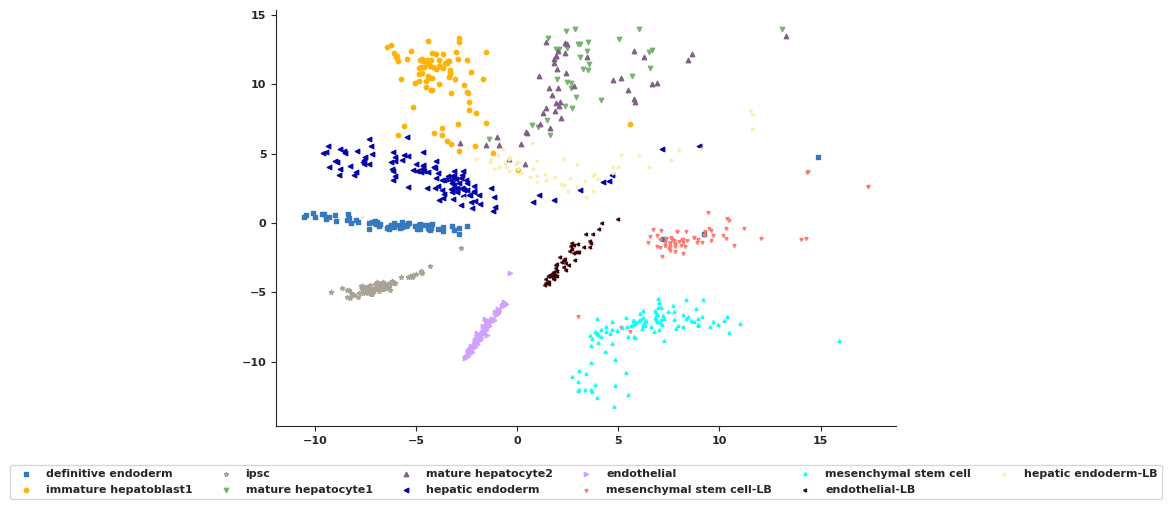

In [ ]:
fig = print_2D(points=res, label=label, id_map=id_map)
fig.show()

In [ ]:
# Tính diffusion map
sc.pp.neighbors(adata_pseudo, use_rep='X_infomax')
sc.tl.diffmap(adata_pseudo)

# Chọn root cell
root_cells1 = adata_pseudo.obs.query("cell_type == 'ipsc'").index
adata_pseudo.uns['iroot'] = np.flatnonzero(adata_pseudo.obs_names.isin(root_cells1))[0]

# Tính DPT (Diffusion Pseudotime)
sc.tl.dpt(adata_pseudo)


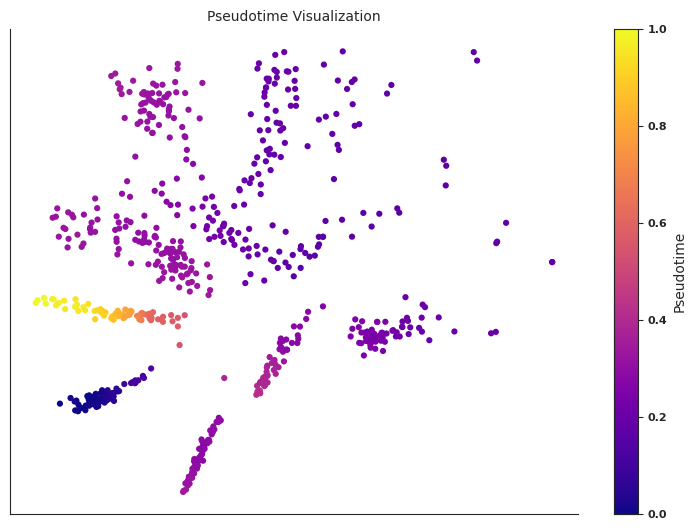

In [ ]:
plt.rcParams['legend.fontsize'] = 8
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8

points = adata_pseudo.obsm['X_infomax']

pseudotime = adata_pseudo.obs['dpt_pseudotime'].values

fig = print_2D_gradient(points=points, values=pseudotime, cmap='plasma')
fig.show()

In [ ]:
adata_pseudo.write_h5ad('/content/drive/MyDrive/Thesis/Implement/Code/Downstream/sc_camp_pseudo.h5ad')
